# Pulsar Star Classification
---
Pulsars are a rate type of Neutro star that produce radio detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and stated of matter. Machine learning tools are now being used to automatically label pulsar candidated to facilitate rapid analysis. Classification systems in particular are being widely adopted, which treat the candidate data sets as binary classification problems.

In [1]:
# Improting Libraries

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
import tqdm as tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

# import train data

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')

In [3]:
train_df.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
id,,,,,,,,,
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


# Understanding data

In [4]:
# Unique data available in output data
train_df.Class.unique()

array([0, 1], dtype=int64)

In [5]:
# Available columns data
train_df.columns

Index(['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class'],
      dtype='object')

# Visualize data

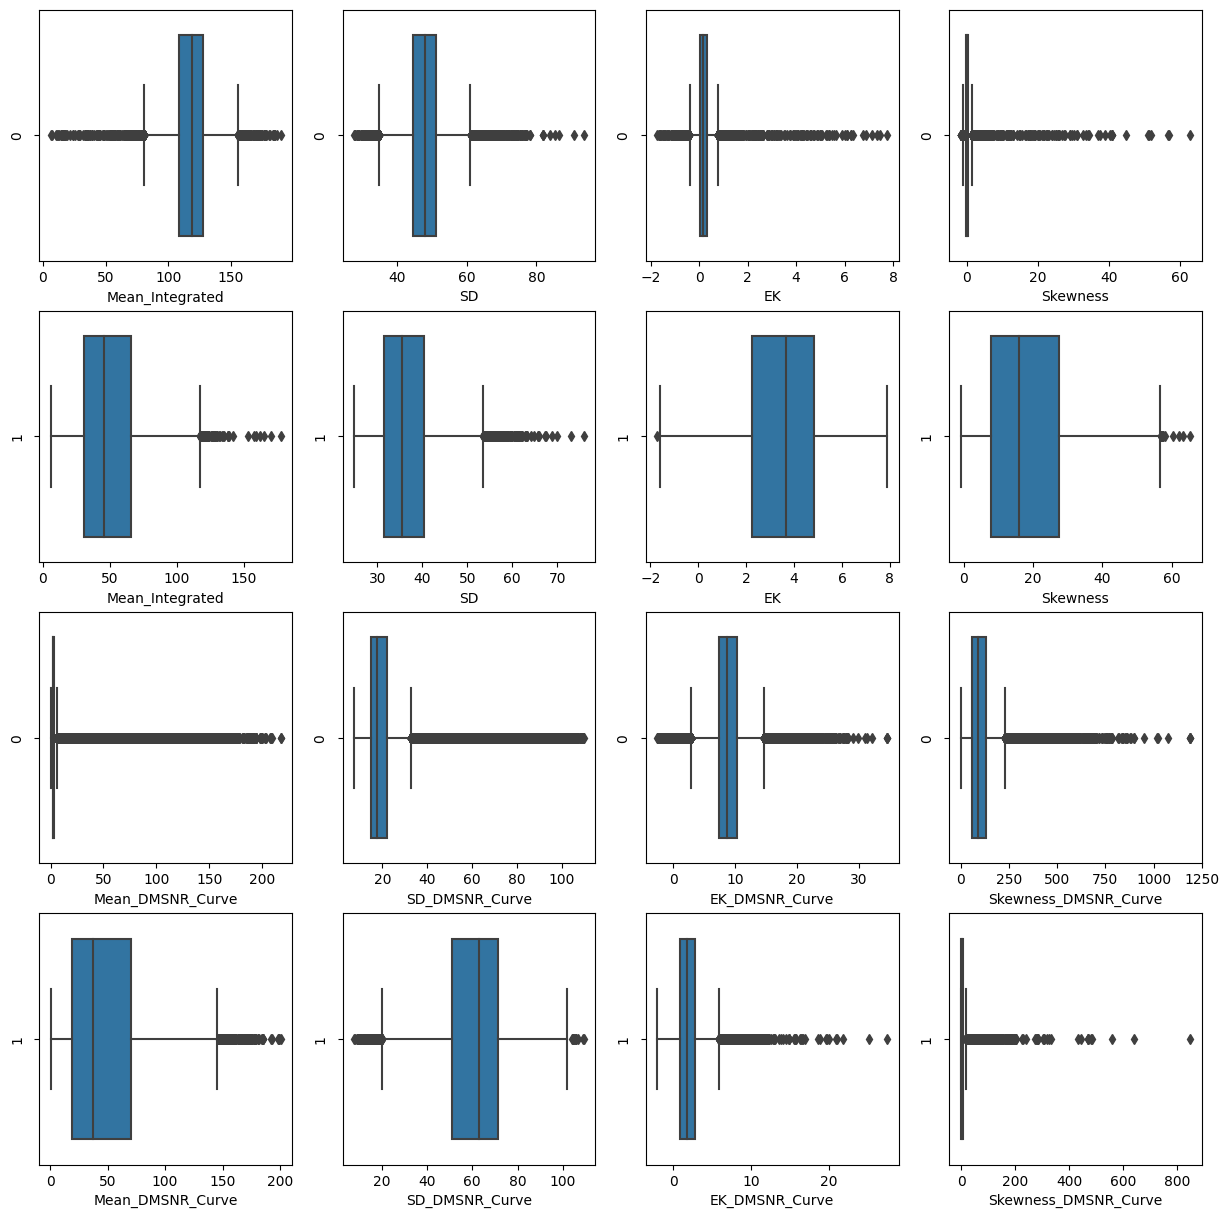

In [6]:
_, ax = plt.subplots(4,4, figsize=(15,15))

cols = train_df.columns[:-1]
for i in range(len(cols)):
    j = 0
    k = i
    if i > 3:
        j += 2
        k = i-4
    zeros = train_df[train_df['Class'] == 0][cols[i]]
    ones = train_df[train_df['Class'] == 1][cols[i]]
    sns.boxplot(zeros, ax = ax[j,k])
    ax[j,k].set(ylabel='0')
    sns.boxplot(ones, ax=ax[j+1,k])
    ax[j+1,k].set(ylabel='1')
    k += 1
    if i >= 3:
        k = 0

# transform data

In [7]:
X = train_df.drop(columns=['Class'])

Y = train_df['Class']

std = StandardScaler()
std.fit(X)

X_std = std.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_std,Y, test_size=0.2, random_state=43)

# Model Training

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = xgb.XGBClassifier()
rf_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [154]:
pred = rf_clf.predict_proba(X_test)
log_loss(Y_test, pred)

0.03198193591842288

In [60]:
accuracy_score(rf_clf.predict(X_test), Y_test)

0.9915365967762514

# Cross Validation

In [167]:
import xgboost as xgb

xgb_params = {
    'max_depth': 15,
    'eta': 0.01,
    'colsample_bytree': 0.71,
    'subsample': 0.8573,
    'min_child_weight': 10,
    'gamma': 0.9882,
     'learning_rate' : 0.1123546,
    'seed': 43,
    'tree_method': 'exact',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

proba = []

# split the data with 10 fold
k = StratifiedKFold(n_splits=10, random_state=43, shuffle=True)

i = 0
for (train_idx, val_idx) in k.split(X_train, Y_train):
    i += 1
    x_train,y_train = x[train_index],y.iloc[train_index] # create train data from index
    x_test,y_test = x[test_index],y.iloc[test_index] # create test data from index

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(x_train, y_train) # train data
    
    val_preds = model.predict_proba(x_test) 
    val_score = log_loss(y_test,np.array(val_preds)) # measure log_loss score
    
    proba.append(model.predict_proba(X_test))
    
    print(f'FOLD {i} | LogLoss: {round(val_score, 4)}')    

FOLD 1 | LogLoss: 0.0298
FOLD 2 | LogLoss: 0.0298
FOLD 3 | LogLoss: 0.0298
FOLD 4 | LogLoss: 0.0298
FOLD 5 | LogLoss: 0.0298
FOLD 6 | LogLoss: 0.0298
FOLD 7 | LogLoss: 0.0298
FOLD 8 | LogLoss: 0.0298
FOLD 9 | LogLoss: 0.0298
FOLD 10 | LogLoss: 0.0298


In [168]:
log_loss(Y_test, np.mean(proba, axis=0))

0.030354197670409023